In [1]:
import numpy as np
import torch
import copy
import scipy 
import copy
import ase
import ase.io
torch.set_default_dtype(torch.float64) 
# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
with torch.no_grad():
       
    xdos = torch.load("./xdos.pt")
    
    total_dos3 = torch.load("./total_ldos3.pt")
    total_dos1 = torch.load("./total_ldos1.pt")
    
    surface_dos3 = torch.load("./surface_ldos3.pt")
    surface_dos1 = torch.load("./surface_ldos1.pt")
    
    surface_aligned_dos3 = torch.load("./surface_aligned_dos3.pt")
    surface_aligned_dos1 = torch.load("./surface_aligned_dos1.pt")
    
    bulk_dos3 = torch.load("./bulk_ldos3.pt")
    bulk_dos1 = torch.load("./bulk_ldos1.pt")
    
    total_aligned_dos3 = torch.load("./total_aligned_dos3.pt")
    total_aligned_dos1 = torch.load("./total_aligned_dos1.pt")
    
    surface_soap = torch.load("./surface_soap.pt")
    bulk_soap = torch.load("./bulk_soap.pt")
    total_soap = torch.load("./total_soap.pt")
    
    surface_kernel_30 = torch.load("./surface_kernel_30.pt")
    surface_kMM_30 = torch.load("./surface_kMM_30.pt")
    
    bulk_kernel_200 = torch.load("./bulk_kernel_200.pt")
    bulk_kMM_200 = torch.load("./bulk_kMM_200.pt")
    
    bulk_kernel_100 = torch.load("./bulk_kernel_100.pt")
    bulk_kMM_100 = torch.load("./bulk_kMM_100.pt")
    
    total_kernel_100 = torch.load("./total_kernel_100.pt")
    total_kMM_100 = torch.load("./total_kMM_100.pt")
    
    total_kernel_150 = torch.load("./total_kernel_150.pt")
    total_kMM_150 = torch.load("./total_kMM_150.pt")
    
    

In [3]:
def generate_train_test_split(n_samples):
    n_structures = n_samples
    np.random.seed(0)
    n_train = int(0.8 * n_structures)
    train_index = np.arange(n_structures)
    np.random.shuffle(train_index)
    test_index = train_index[n_train:]
    train_index = train_index[:n_train]
    
    return train_index, test_index

def generate_biased_train_test_split(n_samples):
    #Assumes 100 amorphous structures at the end
    n_structures = n_samples
    amorph_train = np.arange(n_samples-100, n_samples,1)
    np.random.seed(0)
    np.random.shuffle(amorph_train)
    
    amorph_test = amorph_train[:80]
    amorph_train = amorph_train[80:]

    n_structures = n_samples - 100
    np.random.seed(0)
    n_train = int(0.8 * n_samples)-20
    remaining_train_index = np.arange(n_structures)
    np.random.shuffle(remaining_train_index)

    remaining_test_index = remaining_train_index[n_train:]
    remaining_train_index = remaining_train_index[:n_train]

    biased_train_index = np.concatenate([remaining_train_index, amorph_train])
    biased_test_index = np.concatenate([remaining_test_index, amorph_test])
    
    return biased_train_index, biased_test_index

def generate_surface_holdout_split(n_samples):
    #Assumes that we are using the 110 surfaces for test which are located at 673 + 31st-57th index
    #26 structures
    
    n_test = int(0.2 * n_samples) - 26
    n_train = n_samples - n_test
    
    remaining_indexes = np.concatenate([np.arange(673+31), np.arange(673+57,n_samples,1)])
    indexes_110 = np.arange(673+31, 673+57,1)
    np.random.seed(0)
    
    np.random.shuffle(remaining_indexes)
    
    remaining_test_index = remaining_indexes[n_train:]
    remaining_train_index = remaining_indexes[:n_train]
    
    total_train_index = remaining_train_index
    total_test_index = np.concatenate([remaining_test_index, indexes_110])
    
    return total_train_index, total_test_index
    
def surface_holdout(n_samples):
    test_index = np.arange(31,57,1)
    train_index = np.concatenate([np.arange(31), np.arange(57, n_samples)])
    
    return train_index, test_index

n_surfaces = 154
n_bulkstructures = 773
n_total_structures = 773 + 154


surface_train_index, surface_test_index = generate_train_test_split(n_surfaces)
bulk_train_index, bulk_test_index = generate_train_test_split(n_bulkstructures)
total_train_index, total_test_index = generate_train_test_split(n_total_structures)
surface_holdout_train_index, surface_holdout_test_index = surface_holdout(n_surfaces)
bulk_biased_train_index, bulk_biased_test_index = generate_biased_train_test_split(n_bulkstructures)
total_biased_train_index, total_biased_test_index = generate_biased_train_test_split(n_total_structures)
holdout_train_index, holdout_test_index = generate_surface_holdout_split(n_total_structures)

In [158]:
from scipy.signal import convolve, correlate, correlation_lags
def find_optimal_discrete_shift(prediction, true):
    if true.shape == prediction.shape and len(prediction.shape) == 2:
        shift = []
        for i in range(true.shape[0]):
            corr = correlate(true[i], prediction[i], mode='full')
            shift_i = np.argmax(corr) - len(true[i]) + 1   
            shift.append(shift_i)
        
        
    elif true.shape == prediction.shape and len(prediction.shape) == 1:
        corr = correlate(true, prediction, mode='full')
        shift = np.argmax(corr) - len(true) + 1   
    else:
        print ("input shapes are not the same")
        raise Exception
    return shift


In [159]:
#Generate shifted data
def shifted_ldos_discrete(ldos, xdos, shift): 
    shifted_ldos = torch.zeros_like(ldos)
    if len(ldos.shape) > 1:
        xdos_shift = torch.round(shift).int()
        for i in range(len(ldos)):
            if xdos_shift[i] > 0:
                shifted_ldos[i] = torch.nn.functional.pad(ldos[i,:-1*xdos_shift[i]], (xdos_shift[i],0))
            elif xdos_shift[i] < 0:
                shifted_ldos[i] = torch.nn.functional.pad(ldos[i,(-1*xdos_shift[i]):], (0,(-1*xdos_shift[i])))
            else:
                shifted_ldos[i] = ldos[i]
    else:        
        xdos_shift = int(torch.round(shift))
        if xdos_shift > 0:
            shifted_ldos = torch.nn.functional.pad(ldos[:-1*xdos_shift], (xdos_shift,0))
        elif xdos_shift < 0:
            shifted_ldos = torch.nn.functional.pad(ldos[(-1*xdos_shift):], (0,(-1*xdos_shift)))
        else:
            shifted_ldos = ldos
    return shifted_ldos



In [160]:
def t_get_mse(a, b, xdos = None, perc = False):
    if xdos is not None:
        if len(a.size()) > 1:
            mse = (torch.trapezoid((a - b)**2, xdos, axis=1)).mean()
        else:
            mse = (torch.trapezoid((a - b)**2, xdos, axis=0)).mean()
        if not perc:
            return mse
        else:
            mean = b.mean(axis = 0)
            std = torch.trapezoid((b - mean)**2, xdos, axis=1).mean()
            return (100 * mse / std)
    else:
        if len(a.size()) > 1:
            mse = ((a - b)**2).mean(dim = 1)
        else:
            mse = ((a - b)**2).mean()
        if len(mse.shape) > 1:
            raise ValueError('Loss became 2D')
        if not perc:
            return torch.mean(mse, 0)
        else:
            return torch.mean(100 * (mse / b.std(dim=0, unbiased = True)),0)
        
        
def t_get_rmse(a, b, xdos=None, perc=False): #account for the fact that DOS is continuous but we are training them pointwise
    """ computes  Root Mean Squared Error (RMSE) of array properties (DOS/aofd).
         a=pred, b=target, xdos, perc: if False return RMSE else return %RMSE"""
    #MIGHT NOT WORK FOR PC
    if xdos is not None:
        if len(a.size()) > 1:
            rmse = torch.sqrt((torch.trapezoid((a - b)**2, xdos, axis=1)).mean())
        else:
            rmse = torch.sqrt((torch.trapezoid((a - b)**2, xdos, axis=0)).mean())
        if not perc:
            return rmse
        else:
            mean = b.mean(axis = 0)
            std = torch.sqrt((torch.trapezoid((b - mean)**2, xdos, axis=1)).mean())
            return (100 * rmse / std)
    else:
        if len(a.size()) > 1:
            rmse = torch.sqrt(((a - b)**2).mean(dim =0))
        else:
            rmse = torch.sqrt(((a - b)**2).mean())
        if not perc:
            return torch.mean(rmse, 0)
        else:
            return torch.mean(100 * (rmse / b.std(dim = 0,unbiased=True)), 0)

In [175]:
from dostools.loss import loss

def normal_reg_train_L(feat, target, train_index, test_index, regularization, n_epochs, lr):
    
    patience = 20
    index = train_index
    t_index = test_index
    features = torch.hstack([feat, torch.ones(feat.shape[0]).view(-1,1)])
    Features = features[index]
    t_Features = features[t_index]
    n_col = Features.shape[1]
    Target = target[index]
    t_Target = target[t_index]
    reg = regularization * torch.eye(n_col)
    reg[-1, -1] = 0
    reg_features = torch.vstack([Features, reg])
    reg_target = torch.vstack([Target, torch.zeros(n_col,Target.shape[1])])
    


    weights = torch.nn.Parameter(torch.rand(Features.shape[1], Target.shape[1])- 0.5)
    opt = torch.optim.LBFGS([weights], lr = lr, line_search_fn = "strong_wolfe", tolerance_grad = 1e-20, tolerance_change = 1-20, history_size = 200)
    pbar = tqdm(range(n_epochs))
    current_rmse = torch.tensor(100)
    pred_loss = torch.tensor(100)
    prev_loss = torch.tensor(100)
    best_mse = torch.tensor(100)
    trigger = 0
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
        def closure():
            opt.zero_grad()
            pred_i = reg_features @ weights
            opt_shift = find_optimal_discrete_shift(np.array(pred_i[:len(index)].detach()),np.array(reg_target[:len(index)].detach()))
            pred_i[:len(index)] = shifted_ldos_discrete(pred_i[:len(index)], xdos, torch.tensor(opt_shift))
            loss_i = loss.t_get_mse(pred_i, reg_target)
            loss_i.backward()
            return loss_i
        opt.step(closure)

        with torch.no_grad():
            preds = Features @ weights
            opt_shift = find_optimal_discrete_shift(np.array(preds),np.array(Target))
            preds = shifted_ldos_discrete(preds, xdos, torch.tensor(opt_shift))
            epoch_rmse = loss.t_get_rmse(preds, Target, xdos, perc = True)
            epoch_mse = loss.t_get_mse(preds, Target, xdos)
            
            


            pred_loss = epoch_rmse

            if epoch_mse < best_mse:
                best_mse = epoch_mse
                best_state = weights.clone()

            if epoch_mse < prev_loss * ( 1 + 1e-3):
                trigger =0
            else:
                trigger +=1 
                if trigger >= patience:
                    weights = best_state
                    opt = torch.optim.Adam([weights], lr = opt.param_groups[0]['lr'], weight_decay = 0)

            epoch_mse = prev_loss


    
    with torch.no_grad():
        final_preds = Features @ best_state 
        final_t_preds = t_Features @ best_state

        opt_shift_train = find_optimal_discrete_shift(np.array(final_preds),np.array(Target))
        final_preds = shifted_ldos_discrete(final_preds, xdos, torch.tensor(opt_shift_train))
        opt_shift_test = find_optimal_discrete_shift(np.array(final_t_preds),np.array(t_Target))
        final_t_preds = shifted_ldos_discrete(final_t_preds, xdos, torch.tensor(opt_shift_test))

        loss_dos = loss.t_get_rmse(final_preds, Target, xdos, perc = True)
        test_loss_dos = loss.t_get_rmse(final_t_preds, t_Target, xdos, perc = True)
        return best_state, loss_dos, test_loss_dos
        

def normal_reg_train_Ad(feat, target, train_index, test_index, regularization, n_epochs, batch_size, lr):
    patience = 20
    index = train_index
    t_index = test_index

    features = torch.hstack([feat, torch.ones(feat.shape[0]).view(-1,1)])

    Sampler = torch.utils.data.RandomSampler(index, replacement = False)
    Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

    Features = features[index]
    t_Features = features[t_index]
    n_col = Features.shape[1]


    Target = target[index]
    t_Target = target[t_index]


    # reg_features = torch.vstack([Features, reg])
    # reg_target = torch.vstack([Target, torch.zeros(n_col,Target.shape[1])])


    reg = regularization * torch.eye(n_col)
    reg[-1, -1] = 0


    weights = torch.nn.Parameter((torch.rand(Features.shape[1], Target.shape[1])- 0.5))
    opt = torch.optim.Adam([weights], lr = lr, weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 500, threshold = 1e-7, min_lr = 1e-8)

    pbar = tqdm(range(n_epochs))

    current_rmse = torch.tensor(100)
    pred_loss = torch.tensor(100)
    prev_loss = torch.tensor(100)
    best_mse = torch.tensor(100)
    trigger = 0
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
        for i_batch in Batcher:
            def closure():
                opt.zero_grad()
                reg_features_i = torch.vstack([Features[i_batch], reg])
                target_i = torch.vstack([Target[i_batch], torch.zeros(n_col, Target.shape[1])])
                pred_i = reg_features_i @ weights
                opt_shift = find_optimal_discrete_shift(np.array(pred_i[:len(i_batch)].detach()),np.array(target_i[:len(i_batch)].detach()))
                pred_i[:len(i_batch)] = shifted_ldos_discrete(pred_i[:len(i_batch)], xdos, torch.tensor(opt_shift))
                loss_i = loss.t_get_mse(pred_i, target_i)
                loss_i.backward()
                return loss_i
            opt.step(closure)

        with torch.no_grad():
            preds = Features @ weights
            opt_shift = find_optimal_discrete_shift(np.array(preds),np.array(Target))
            preds = shifted_ldos_discrete(preds, xdos, torch.tensor(opt_shift))
            epoch_rmse = loss.t_get_rmse(preds, Target, xdos, perc = True)
            epoch_mse = loss.t_get_mse(preds, Target, xdos)


            pred_loss = epoch_rmse

            if epoch_mse < best_mse:
                best_mse = epoch_mse
                best_state = weights.clone()

            if epoch_mse < prev_loss * ( 1 + 1e-3):
                trigger =0
            else:
                trigger +=1 
                if trigger >= patience:
                    weights = best_state
                    opt = torch.optim.Adam([weights], lr = opt.param_groups[0]['lr'], weight_decay = 0)

            epoch_mse = prev_loss

            scheduler.step(epoch_mse)

            if Batcher.batch_size > 1024:
                break

            if opt.param_groups[0]['lr'] < 1e-4:
                Batcher.batch_size *= 2
                opt.param_groups[0]['lr'] = lr
                print ("The batch_size is now: ", Batcher.batch_size)

    
    with torch.no_grad():
        final_preds = Features @ best_state 
        final_t_preds = t_Features @ best_state

        opt_shift_train = find_optimal_discrete_shift(np.array(final_preds),np.array(Target))
        final_preds = shifted_ldos_discrete(final_preds, xdos, torch.tensor(opt_shift_train))
        opt_shift_test = find_optimal_discrete_shift(np.array(final_t_preds),np.array(t_Target))
        final_t_preds = shifted_ldos_discrete(final_t_preds, xdos, torch.tensor(opt_shift_test))

        loss_dos = loss.t_get_rmse(final_preds, Target, xdos, perc = True)
        test_loss_dos = loss.t_get_rmse(final_t_preds, t_Target, xdos, perc = True)
        return best_state, loss_dos, test_loss_dos
        

In [171]:
# #For mass production
# def normal_reg_train_L(feat, target, train_index, test_index, regularization, n_epochs, lr):    
#     patience = 20
#     index = train_index
#     t_index = test_index
#     features = torch.hstack([feat, torch.ones(feat.shape[0]).view(-1,1)])
#     Features = features[index]
#     t_Features = features[t_index]
#     n_col = Features.shape[1]
#     Target = target[index]
#     t_Target = target[t_index]
#     reg = regularization * torch.eye(n_col)
#     reg[-1, -1] = 0
#     reg_features = torch.vstack([Features, reg])
#     reg_target = torch.vstack([Target, torch.zeros(n_col,Target.shape[1])])
    
#     weights = torch.nn.Parameter(torch.rand(Features.shape[1], Target.shape[1])- 0.5)
#     opt = torch.optim.LBFGS([weights], lr = lr, line_search_fn = "strong_wolfe", tolerance_grad = 1e-20, tolerance_change = 1-20, history_size = 200)
    
#     for epoch in range(n_epochs):
#         def closure():
#             opt.zero_grad()
#             pred_i = reg_features @ weights
#             opt_shift = find_optimal_discrete_shift(np.array(pred_i[:len(index)].detach()),np.array(reg_target[:len(index)].detach()))
#             pred_i[:len(index)] = shifted_ldos_discrete(pred_i[:len(index)], xdos, torch.tensor(opt_shift))
#             loss_i = t_get_mse(pred_i, reg_target)
#             loss_i.backward()
#             return loss_i
#         opt.step(closure)
    
#     with torch.no_grad():
#         final_preds = Features @ best_state 
#         final_t_preds = t_Features @ best_state

#         opt_shift_train = find_optimal_discrete_shift(np.array(final_preds),np.array(Target))
#         final_preds = shifted_ldos_discrete(final_preds, xdos, torch.tensor(opt_shift_train))
#         opt_shift_test = find_optimal_discrete_shift(np.array(final_t_preds),np.array(t_Target))
#         final_t_preds = shifted_ldos_discrete(final_t_preds, xdos, torch.tensor(opt_shift_test))

#         loss_dos = t_get_rmse(final_preds, Target, xdos, perc = True)
#         test_loss_dos = t_get_rmse(final_t_preds, t_Target, xdos, perc = True)
#         return best_state, loss_dos, test_loss_dos
        

# def normal_reg_train_Ad(feat, target, train_index, test_index, regularization, n_epochs, batch_size, lr):
#     patience = 20
#     index = train_index
#     t_index = test_index

#     features = torch.hstack([feat, torch.ones(feat.shape[0]).view(-1,1)])

#     Sampler = torch.utils.data.RandomSampler(index, replacement = False)
#     Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

#     Features = features[index]
#     t_Features = features[t_index]
#     n_col = Features.shape[1]


#     Target = target[index]
#     t_Target = target[t_index]


#     # reg_features = torch.vstack([Features, reg])
#     # reg_target = torch.vstack([Target, torch.zeros(n_col,Target.shape[1])])


#     reg = regularization * torch.eye(n_col)
#     reg[-1, -1] = 0


#     weights = torch.nn.Parameter((torch.rand(Features.shape[1], Target.shape[1])- 0.5))
#     opt = torch.optim.Adam([weights], lr = lr, weight_decay = 0)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 500, threshold = 1e-7, min_lr = 1e-8)

#     best_mse = torch.tensor(100)
#     for epoch in tqdm(range(n_epochs))yy:
#         for i_batch in Batcher:
#             def closure():
#                 opt.zero_grad()
#                 reg_features_i = torch.vstack([Features[i_batch], reg])
#                 target_i = torch.vstack([Target[i_batch], torch.zeros(n_col, Target.shape[1])])
#                 pred_i = reg_features_i @ weights
#                 opt_shift = find_optimal_discrete_shift(np.array(pred_i[:len(i_batch)].detach()),np.array(target_i[:len(i_batch)].detach()))
#                 pred_i[:len(i_batch)] = shifted_ldos_discrete(pred_i[:len(i_batch)], xdos, torch.tensor(opt_shift))
#                 loss_i = t_get_mse(pred_i, target_i)
#                 loss_i.backward()
#                 return loss_i
#             opt.step(closure)

#         with torch.no_grad():
#             preds = Features @ weights
#             opt_shift = find_optimal_discrete_shift(np.array(preds),np.array(Target))
#             preds = shifted_ldos_discrete(preds, xdos, torch.tensor(opt_shift))
#             epoch_rmse = t_get_rmse(preds, Target, xdos, perc = True)
#             epoch_mse = t_get_mse(preds, Target, xdos)


#             pred_loss = epoch_rmse

#             if epoch_mse < best_mse:
#                 best_mse = epoch_mse
#                 best_state = weights.clone()

#             scheduler.step(epoch_mse)

#             if Batcher.batch_size > 1024:
#                 break

#             if opt.param_groups[0]['lr'] < 1e-4:
#                 Batcher.batch_size *= 2
#                 opt.param_groups[0]['lr'] = lr
#                 print ("The batch_size is now: ", Batcher.batch_size)

    
#     with torch.no_grad():
#         final_preds = Features @ best_state 
#         final_t_preds = t_Features @ best_state

#         opt_shift_train = find_optimal_discrete_shift(np.array(final_preds),np.array(Target))
#         final_preds = shifted_ldos_discrete(final_preds, xdos, torch.tensor(opt_shift_train))
#         opt_shift_test = find_optimal_discrete_shift(np.array(final_t_preds),np.array(t_Target))
#         final_t_preds = shifted_ldos_discrete(final_t_preds, xdos, torch.tensor(opt_shift_test))

#         loss_dos = t_get_rmse(final_preds, Target, xdos, perc = True)
#         test_loss_dos = t_get_rmse(final_t_preds, t_Target, xdos, perc = True)
#         return best_state, loss_dos, test_loss_dos
        

In [166]:
def evaluate_weights(weights, feat, target, train_index, test_index):
    
    features = torch.hstack([feat, torch.ones(feat.shape[0]).view(-1,1)])
    
    best_state = weights
    Features = features[train_index]
    t_Features = features[test_index]
    
    Target = target[train_index]
    t_Target = target[test_index]
    
    with torch.no_grad():
        final_preds = Features @ best_state 
        final_t_preds = t_Features @ best_state

        opt_shift_train = find_optimal_discrete_shift(np.array(final_preds),np.array(Target))
        final_preds = shifted_ldos_discrete(final_preds, xdos, torch.tensor(opt_shift_train))
        opt_shift_test = find_optimal_discrete_shift(np.array(final_t_preds),np.array(t_Target))
        final_t_preds = shifted_ldos_discrete(final_t_preds, xdos, torch.tensor(opt_shift_test))

        loss_dos = t_get_rmse(final_preds, Target, xdos, perc = True)
        test_loss_dos = t_get_rmse(final_t_preds, t_Target, xdos, perc = True)
    
    return loss_dos, test_loss_dos, opt_shift_train, opt_shift_test

In [167]:
def get_predictions(weights, feat, target, train_index, test_index):
    features = torch.hstack([feat, torch.ones(feat.shape[0]).view(-1,1)])
    
    best_state = weights
    Features = features[train_index]
    t_Features = features[test_index]
    
    Target = target[train_index]
    t_Target = target[test_index]
    
    with torch.no_grad():
        final_preds = Features @ best_state 
        final_t_preds = t_Features @ best_state

        opt_shift_train = find_optimal_discrete_shift(np.array(final_preds),np.array(Target))
        final_preds2 = shifted_ldos_discrete(final_preds, xdos, torch.tensor(opt_shift_train))
        opt_shift_test = find_optimal_discrete_shift(np.array(final_t_preds),np.array(t_Target))
        final_t_preds2 = shifted_ldos_discrete(final_t_preds, xdos, torch.tensor(opt_shift_test))
        
    return final_preds, final_t_preds, opt_shift_train, opt_shift_test

In [139]:
# adam_opt_weights = weights.clone()
loss_dos, test_loss_dos, opt_shift_train, opt_shift_test = evaluate_weights(adam_opt_weights, total_soap, total_aligned_dos3, total_train_index, total_test_index)

print ("The train error is {:.4} for SOAP".format(loss_dos))
print ("The test error is {:.4} for SOAP".format(test_loss_dos))

The train error is 19.83 for SOAP
The test error is 22.49 for SOAP


In [151]:
train_pred, test_pred, train_shift, test_shift = get_predictions(adam_opt_weights, total_soap, total_aligned_dos3, total_train_index, total_test_index)
torch.save(torch.tensor(train_shift), "./adam_corr_train_shifts.pt")
torch.save(torch.tensor(test_shift), "./adam_corr_test_shifts.pt")

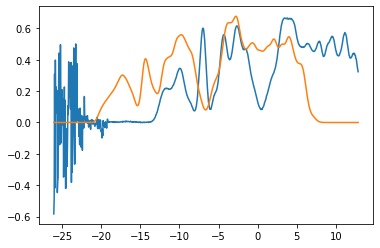

In [156]:
i = 454
plt.plot(xdos, train_pred[i])
plt.plot(xdos, total_aligned_dos3[total_train_index[i]])

In [173]:
aweights, loss_dos, test_loss_dos = normal_reg_train_Ad(total_soap, total_aligned_dos3,
                                                       total_train_index, total_test_index,
                                                       1e-2, 20000, 60, 1e-3)


print ("Adam Unbiased")
print ("The train error is {:.4} for SOAP".format(loss_dos))
print ("The test error is {:.4} for SOAP".format(test_loss_dos))

  0%|                                                                                                                                                                          | 5/20000 [00:03<3:23:15,  1.64it/s]


KeyboardInterrupt: 

In [136]:
weights, loss_dos, test_loss_dos = normal_reg_train_Ad(surface_soap, surface_dos3, surface_train_index, surface_test_index, 1e-2, 10000, 16, 1e-3)
print ("Adam Unbiased")
print ("The train error is {:.4} for SOAP".format(loss_dos))
print ("The test error is {:.4} for SOAP".format(test_loss_dos))

Epoch: 1005:  10%|███████████                                                                                                   | 1005/10000 [01:53<15:39,  9.57it/s, lowest_mse=0.0152, pred_loss=46.7, trigger=0]

The batch_size is now:  32


Epoch: 2007:  20%|█████████████████████▉                                                                                       | 2007/10000 [03:28<12:29, 10.66it/s, lowest_mse=0.00871, pred_loss=35.4, trigger=0]

The batch_size is now:  64


Epoch: 3009:  30%|████████████████████████████████▊                                                                            | 3009/10000 [04:58<10:23, 11.22it/s, lowest_mse=0.00751, pred_loss=32.8, trigger=0]

The batch_size is now:  128


Epoch: 4011:  40%|███████████████████████████████████████████▋                                                                 | 4010/10000 [06:27<08:41, 11.50it/s, lowest_mse=0.00695, pred_loss=31.6, trigger=0]

The batch_size is now:  256


Epoch: 5013:  50%|██████████████████████████████████████████████████████▋                                                      | 5013/10000 [07:56<07:13, 11.51it/s, lowest_mse=0.00656, pred_loss=30.7, trigger=0]

The batch_size is now:  512


Epoch: 6015:  60%|██████████████████████████████████████████████████████████████████▊                                            | 6015/10000 [09:23<05:45, 11.54it/s, lowest_mse=0.00628, pred_loss=30, trigger=0]

The batch_size is now:  1024


Epoch: 7015:  70%|████████████████████████████████████████████████████████████████████████████▍                                | 7015/10000 [10:50<04:36, 10.78it/s, lowest_mse=0.00604, pred_loss=29.4, trigger=0]


The batch_size is now:  2048
Adam Unbiased
The train error is 29.43 for SOAP
The test error is 38.52 for SOAP


22.36, 24.29

In [135]:
U_L_weights3 , loss_dos, test_loss_dos = normal_reg_train_L(total_soap, total_aligned_dos3,
                                                            total_train_index, total_test_index,
                                                            1e-2, 30, 1)
print ("LBFGS Unbiased")
print ("The train error is {:.4} for SOAP".format(loss_dos))
print ("The test error is {:.4} for SOAP".format(test_loss_dos))

Epoch: 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:13<00:00,  8.44s/it, lowest_mse=0.0537, pred_loss=49.2, trigger=0]


LBFGS Unbiased
The train error is 49.19 for SOAP
The test error is 49.19 for SOAP


In [132]:
U_L_weights3 , loss_dos, test_loss_dos = normal_reg_train_L(surface_soap, surface_dos3, surface_train_index, surface_test_index,
                                                            1e-2, 60, 1)
print ("LBFGS Unbiased")
print ("The train error is {:.4} for SOAP".format(loss_dos))
print ("The test error is {:.4} for SOAP".format(test_loss_dos))

Epoch: 4:   7%|████████                                                                                                                 | 4/60 [00:07<01:50,  1.98s/it, lowest_mse=0.259, pred_loss=193, trigger=0]


KeyboardInterrupt: 